## 【成功，同业存单数据透视表取数,heat map】yivermouth财经周报

In [1]:
from WindPy import w
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pd.set_option('colheader_justify','center')
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.width', 1000) # 设置打印宽度(**重要**)
#以下为解决中文无法显示的问题
#针对matplotlib
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']

In [2]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~设置起、止日期~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

enddate = datetime.date.today()

startdate = enddate + datetime.timedelta(days=-7)       #“-7”代表往前7天

start_date = startdate.strftime('%Y/%m/%d')    #加不加“%H:%M:%S”无所谓

end_date = enddate.strftime('%Y/%m/%d')


print(start_date,type(start_date),end_date,type(end_date))

2023/03/19 <class 'str'> 2023/03/26 <class 'str'>


In [4]:
CD_data = w.wset("nationaldebtissueandclosesub",
           "startdate="+start_date+";enddate="+end_date+";frequency=weekly;maingrade=all;zxgrade=all;datetype=startdate;type=default;bondtype=cds;bondid=1000008489000000,a101020100000000,a101020200000000,a101020300000000,1000011872000000,a101020400000000,a101020700000000,a101020800000000,a101020b00000000,a101020500000000,1000013981000000,1000002993000000,1000004571000000,a101020a00000000,a101020600000000,1000016455000000,a101020900000000;field=startdate,windcode,name,issueprice,term,mainrating,issuerate,tradepartcompanycharacter",
           #"+start_date+"为wind专用格式——from官方客服                                              
            usedf=True)                                                                         

CD_data = CD_data[1] #奇怪的很，不加[1]就是一个只有2个元素的tuple，第一个元素是一个"0"，所以取第二个元素，是一整个dataframe

#增加发行人【银行类型】——使用 w.wss()函数查询
CD_data["issuer_banktype"] = w.wss(list(CD_data["windcode"]), "issuer_banktype",usedf=True)[1].values


#修改列名”
CD_data.rename(columns={'issueprice':'issueAmount(real)', 
                        'mainrating':'Mainrating',
                       'term':'year'},# Mainrating为主体评级       
               inplace=True) 


#计算CD期限（天）——因为wind的数据是year（小数点），先转换为天，为了下一步方便标准化分类
CD_data['day'] = np.round(CD_data['year']*365, decimals = 1)


#将列“day”进行分类——chatgpt

bins = [0, 60, 120, 210, 300, 365]
labels = ['1M', '3M', '6M', '9M', '1Y']
term = pd.cut(CD_data['day'], bins=bins, labels=labels, right=True) #当right=True时，则 bins=[1、2、3、4]表示（1,2]，（2,3],（3,4]


#在索引为5的位置插入一列“term”
CD_data.insert(5, 'term',term )

CD_data
#-------------------------------------------------------------------------------------------------------------------------------------
#【注】：下图中“issueAmount(real)”为【实际发行量】——是【完全正确无误】的，可以放心使用

# wind界面导出来的分为【计划发行规模】和【发行规模】，且【发行规模】显示还会有问题，比如一般发满则显示为空，但是时候发满了也会显示总规模

# CD不像债券一样，可以实际发行量 < 计划发行量，如果当天设置了发行额度且无任何人来认购，才会发行失败

,startdate,windcode,name,issueAmount(real),year,term,Mainrating,issuerate,tradepartcompanycharacter,issuer_banktype,day
1,2023-03-24,112395632.IB,23广西北部湾银行CD109,10.0,0.5041,6M,AAA,2.65,地方国有企业,城市商业银行,184.0
2,2023-03-24,112395631.IB,23湖南银行CD034,16.5,0.5041,6M,AAA,2.58,地方国有企业,城市商业银行,184.0
3,2023-03-24,112395630.IB,23厦门国际银行CD040,1.2,1.0000,1Y,AAA,2.72,地方国有企业,城市商业银行,365.0
4,2023-03-24,112395629.IB,23湖南银行CD033,12.0,0.2521,3M,AAA,2.48,地方国有企业,城市商业银行,92.0
5,2023-03-24,112395628.IB,23天津滨海农村商行CD078,1.5,0.2521,3M,AA+,2.65,地方国有企业,农村商业银行,92.0
...,...,...,...,...,...,...,...,...,...,...,...
489,2023-03-20,112309069.IB,23浦发银行CD069,0.5,1.0000,1Y,AAA,2.65,地方国有企业,股份制商业银行,365.0
490,2023-03-20,112309068.IB,23浦发银行CD068,0.3,0.7534,9M,AAA,2.55,地方国有企业,股份制商业银行,275.0
491,2023-03-20,112308058.IB,23中信银行CD058,1.0,0.5041,6M,AAA,2.50,中央国有企业,股份制商业银行,184.0
492,2023-03-20,112306113.IB,23交通银行CD113,1.0,1.0000,1Y,AAA,2.65,中央国有企业,国有大型商业银行,365.0


In [5]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~创建数据透视表(.pivot_table())~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# df.pivot_table(values=None, index=None, columns=None, aggfunc='mean', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False, sort=True)
# 这里常用的几个参数：value就是待聚合的值，index就是索引变量（可以双重变量），columns就是列变量（可以双重变量），
# aggfunc是可以给list用以一次性进行多种聚合操作，如果列变量选了双重变量，也可以给dict，即margins表示边界值，
# 默认是FALSE，名字默认为’ALL’可以在margins_name修改。
# 原文链接：https://blog.csdn.net/Mart_inn/article/details/122216010

In [6]:
# 数据透视——发行量

                            #可以多维，如：index=['term','Mainrating']
CD_IA = CD_data.pivot_table(index=['term'],columns=['issuer_banktype'],aggfunc='sum',
                            values='issueAmount(real)',fill_value="-",
                            margins=True, margins_name='Total' #margins=True才显示最边上的加总额
                           )
                                                  
#CD_IA.fillna("-")  #仅适用最边上的margin列，表格里的Nan值只要是多维就自动变成0，没发现怎么改

#重新排序列的顺序
CD_IA_reindex_list = ['国有大型商业银行','股份制商业银行','城市商业银行','农村商业银行','农村信用社','民营银行','外资法人银行',
                      '村镇银行','Total']
                          
CD_IA = CD_IA.reindex(columns = CD_IA_reindex_list)

CD_IA

issuer_banktype,国有大型商业银行,股份制商业银行,城市商业银行,农村商业银行,农村信用社,民营银行,外资法人银行,村镇银行,Total
term,,,,,,,,,
1M,90.0,53.1,441.8,53.8,2,1.1,0.0,NaN,641.8
3M,49.0,165.2,358.1,54.0,0,6.3,0.0,NaN,632.6
6M,0.0,8.5,402.7,166.2,0,2.7,0.0,NaN,580.1
9M,0.0,22.2,248.2,59.6,0,2.6,11.9,NaN,344.5
1Y,626.9,822.6,411.8,37.9,0,8.0,0.0,NaN,1907.2
Total,765.9,1071.6,1862.6,371.5,2,20.7,11.9,NaN,4106.2


## 画图

In [7]:
#~~~~~~~~~~~~~~~为了下面不显示最边上的total行和列，所以要让margins=False
CD_IA_forMP = CD_data.pivot_table(index=['term'],columns=['issuer_banktype'],aggfunc='sum',
                            values='issueAmount(real)',fill_value="-",
                            margins=False  #margins=True才显示最边上的加总额
                           )
CD_IA_forMP = CD_IA_forMP.fillna(0)

#重新排序列的顺序
CD_IA_forMP_reindex_list = ['国有大型商业银行','股份制商业银行','城市商业银行','农村商业银行','农村信用社','民营银行','外资法人银行',
                      '村镇银行']
                          
CD_IA_forMP = CD_IA_forMP.reindex(columns = CD_IA_forMP_reindex_list)

CD_IA_forMP #此为画图的【input】

issuer_banktype,国有大型商业银行,股份制商业银行,城市商业银行,农村商业银行,农村信用社,民营银行,外资法人银行,村镇银行
term,,,,,,,,
1M,90.0,53.1,441.8,53.8,2,1.1,0.0,NaN
3M,49.0,165.2,358.1,54.0,0,6.3,0.0,NaN
6M,0.0,8.5,402.7,166.2,0,2.7,0.0,NaN
9M,0.0,22.2,248.2,59.6,0,2.6,11.9,NaN
1Y,626.9,822.6,411.8,37.9,0,8.0,0.0,NaN


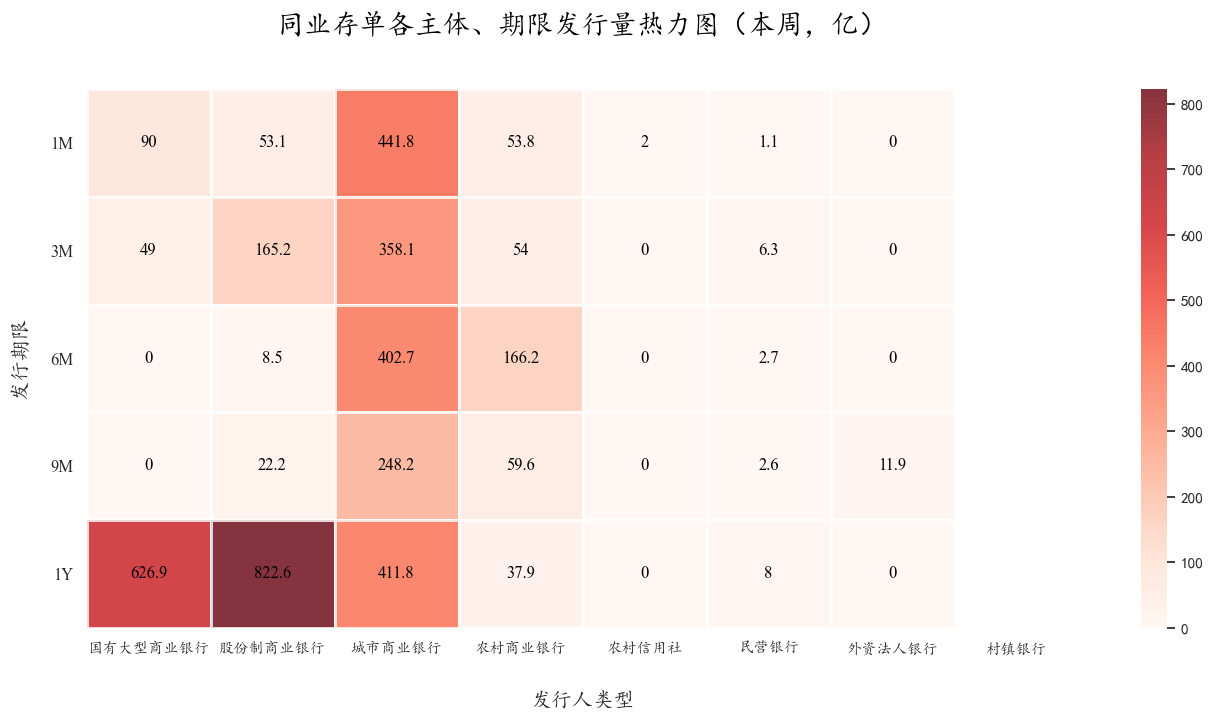

In [8]:
sns.set(font='KaiTi',style='white') #此行为正常显示中文：这里选择为楷体

plt.figure(figsize=(16,7))
# sns.set_context({"figure.figsize":(16,7)})
# sns.set_style('white') #有darkgrid（灰色背景+白网格）、whitegrid（白色背景+黑网格）、dark（仅灰色背景）、white（仅白色背景）
#                       #、ticks（坐标轴带刻度）5种预设的主题

sns.heatmap(CD_IA_forMP, annot=True, fmt='g',annot_kws={"family":"Times New Roman","size": 12,'color':'black'},cmap="Reds",
            cbar=True,cbar_kws={'orientation': 'vertical'},mask=False,linewidth=.8,linecolor='white',alpha=0.8,square=False)
# 【好看的cmp】：后面加"_r"即代表色带相反——Greens Oranges OrRd summer summer_r vlag Wistia Blues RdBu_r Reds

# annot: 默认为False，为True的话，会在格子上显示数字
# annot_kws={"family":"Times New Roman","size": 12,'color':'black'} 修改方格内字体大小、颜色等
# mask可以设置条件判断，如：mask=(CD_IR<=0)
# square : 为‘True’时，整个网格为一个正方形
# cbar=True——显示右方颜色条

plt.title('同业存单各主体、期限发行量热力图（本周，亿）', fontsize = 20,color='black',fontweight='bold',
          bbox=dict(ec='w',fc ='white'), #facecolor(简写fc)背景颜色, edgecolor(简写ec)边框线条颜色                                                   
          fontstyle='normal',family='KaiTi',pad =40  # pad为调整标题与图片的距离
         )
plt.xlabel('发行人类型',family='KaiTi', fontsize = 15, fontweight='bold', labelpad=25) 
plt.ylabel('发行期限',family='KaiTi',fontweight='bold',fontsize = 15, labelpad=15, rotation=90)

# #调整y轴【刻度】显示
plt.xticks(rotation=0)
plt.yticks(fontsize=10,fontproperties = 'Times New Roman',verticalalignment='center_baseline',rotation=0)

#horizontalalignment='left',multialignment='left',
# horizontalalignment，控制文本的 x 位置参数，对齐左侧、中心或右侧:'center', 'right', 'left'
# verticalalignment 控制文本的 y 位置参数，对齐底部、中心或顶部:'top', 'bottom', 'center', 'baseline', 'center_baseline'
# multialignment，仅用于换行符分隔的字符串，控制不同的行是左对齐、居中还是右对齐。

plt.show()

In [9]:
# plt.figure(figsize=(16,7))
# sns.set_style("white")
# sns.scatterplot(x=CD_IA.index, y=CD_IA['国有大型商业银行'],label='国有大型商业银行',size=CD_IA['国有大型商业银行'],
#                 hue=CD_IA['国有大型商业银行'],edgecolor="white",linewidth=2,sizes=(0, 900))

# # sns.scatterplot(x=CD_IA.index, y=CD_IA['股份制商业银行'],label='股份制商业银行',sizes=CD_IA['股份制商业银行']*10)palette="Blues_r"

# plt.xlabel("x")
# plt.ylabel("y")
# plt.title("Scatter Plot of A, B, and C")
# plt.legend()
# plt.show()

In [10]:
# plt.scatter(x = CD_IA.index, y = CD_IA['农村信用社'],label='农村信用社')
# plt.scatter(x = CD_IA.index, y = CD_IA['农村商业银行'],label='农村商业银行')
# sns.scatterplot(x = CD_IA.index, y = CD_IA['国有大型商业银行'],label='国有大型商业银行',sizes=CD_IA['国有大型商业银行']**0.5 * 50)
# plt.scatter(x = CD_IA.index, y = CD_IA['城市商业银行'],label='城市商业银行')
# plt.scatter(x = CD_IA.index, y = CD_IA['外资法人银行'],label='外资法人银行')
# plt.scatter(x = CD_IA.index, y = CD_IA['民营银行'],label='民营银行')
# plt.scatter(x = CD_IA.index, y = CD_IA['股份制商业银行'],label='股份制商业银行')
# plt.legend()
# plt.show()

<br>

## 【发行量】展示DataFrame——发行利率

In [11]:
CD_IR_for_show = CD_data.pivot_table(index=['term','Mainrating'],columns='issuer_banktype',aggfunc='mean',values='issuerate')
CD_IR_for_show = CD_IR_for_show.round(2) #如果上一行的函数加了参数fill_value="-"，会和这里冲突，导致此行代码失效，所以放在下一行再来处理
CD_IR_for_show = CD_IR_for_show.fillna("-")

#重新排序列的顺序
CD_IR_for_show_reindex_list = ['国有大型商业银行','股份制商业银行','城市商业银行','农村商业银行','农村信用社','民营银行','外资法人银行',
                      '村镇银行']
                          
CD_IR_for_show = CD_IR_for_show.reindex(columns = CD_IR_for_show_reindex_list)

CD_IR_for_show

issuer_banktype 国有大型商业银行 股份制商业银行 城市商业银行 农村商业银行 农村信用社 民营银行 外资法人银行  村镇银行
term Mainrating                                                                                                     
1M   AA                  -               -             -         2.71           -       2.7          -        NaN   
     AA+                 -               -          2.58         2.63           -       2.6          -        NaN   
     AA-                 -               -             -         2.72         2.9         -          -        NaN   
     AAA              2.35            2.37          2.56         2.58           -         -          -        NaN   
3M   A                   -               -             -         2.47           -         -          -        NaN   
     A+                  -               -             -          2.7           -         -          -        NaN   
     AA                  -               -             -         2.68           -      2.86          -        NaN   
     AA+                 -               -          2.64         2.64           -         -          -        NaN   
     AA-                 -               -             -          2.9           -         -          -        NaN   
     AAA              2.42            2.41          2.53            -           -         -          -        NaN   
6M   AA                  -               -             -         2.81           -       3.0          -        NaN   
     AA+                 -               -          2.74         2.76           -       3.0          -        NaN   
     AA-                 -               -             -         2.66           -         -          -        NaN   
     AAA                 -             2.5          2.61         2.58           -         -          -        NaN   
9M   AA                  -               -           2.9         2.84           -      3.08        3.1        NaN   
     AA+                 -               -          2.83         2.84           -       3.0          -        NaN   
     AAA                 -            2.59          2.68         2.61           -         -        2.8        NaN   
1Y   AA                  -               -          3.12            -           -      3.24          -        NaN   
     AA+                 -               -           2.9         2.89           -      3.19          -        NaN   
     AA-                 -               -             -          3.2           -         -          -        NaN   
     AAA              2.65            2.66          2.74         2.71           -         -          -        NaN

<br>

## 【发行利率】——热力图

In [12]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~为了画图的前置步骤~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#因为热力图中每个格子都是按照数据类型为float来计量的，但上图中“-”不能转化为浮点数，所以要重新建设一个表格，以Nan值展示

# 数据透视——发行利率【平均值】
CD_IR = CD_data.pivot_table(index=['term','Mainrating'],columns='issuer_banktype',aggfunc='mean',values='issuerate')
CD_IR = CD_IR.round(2) #如果上一行的函数加了参数fill_value="-"，会和这里冲突，导致此行代码失效，所以放在下一行再来处理

#重新排序列的顺序
CD_IR_reindex_list = ['国有大型商业银行','股份制商业银行','城市商业银行','农村商业银行','农村信用社','民营银行','外资法人银行',
                      '村镇银行']
                          
CD_IR = CD_IR.reindex(columns = CD_IR_reindex_list)

CD_IR #此为下图的【input】


#下面的图由于更改了y轴刻度为靠左对齐，导致和图片有重叠（不好看），所以我想着插入一列空值来变相让图片右移动，但是此方法行不通
# CD_IR[''] = pd.Series([None] * len(CD_IR))
# CD_IR.insert(0, '111', CD_IR.pop('')) #通过使用 pop 方法将 'col2' 列弹出，然后使用 insert 方法将该列插入到索引为 0 的位置

issuer_banktype  国有大型商业银行  股份制商业银行  城市商业银行  农村商业银行  农村信用社  民营银行  外资法人银行  村镇银行
term Mainrating                                                                                                            
1M   AA                 NaN              NaN            NaN          2.71          NaN       2.70         NaN        NaN   
     AA+                NaN              NaN           2.58          2.63          NaN       2.60         NaN        NaN   
     AA-                NaN              NaN            NaN          2.72          2.9        NaN         NaN        NaN   
     AAA               2.35             2.37           2.56          2.58          NaN        NaN         NaN        NaN   
3M   A                  NaN              NaN            NaN          2.47          NaN        NaN         NaN        NaN   
     A+                 NaN              NaN            NaN          2.70          NaN        NaN         NaN        NaN   
     AA                 NaN              NaN            NaN          2.68          NaN       2.86         NaN        NaN   
     AA+                NaN              NaN           2.64          2.64          NaN        NaN         NaN        NaN   
     AA-                NaN              NaN            NaN          2.90          NaN        NaN         NaN        NaN   
     AAA               2.42             2.41           2.53           NaN          NaN        NaN         NaN        NaN   
6M   AA                 NaN              NaN            NaN          2.81          NaN       3.00         NaN        NaN   
     AA+                NaN              NaN           2.74          2.76          NaN       3.00         NaN        NaN   
     AA-                NaN              NaN            NaN          2.66          NaN        NaN         NaN        NaN   
     AAA                NaN             2.50           2.61          2.58          NaN        NaN         NaN        NaN   
9M   AA                 NaN              NaN           2.90          2.84          NaN       3.08         3.1        NaN   
     AA+                NaN              NaN           2.83          2.84          NaN       3.00         NaN        NaN   
     AAA                NaN             2.59           2.68          2.61          NaN        NaN         2.8        NaN   
1Y   AA                 NaN              NaN           3.12           NaN          NaN       3.24         NaN        NaN   
     AA+                NaN              NaN           2.90          2.89          NaN       3.19         NaN        NaN   
     AA-                NaN              NaN            NaN          3.20          NaN        NaN         NaN        NaN   
     AAA               2.65             2.66           2.74          2.71          NaN        NaN         NaN        NaN

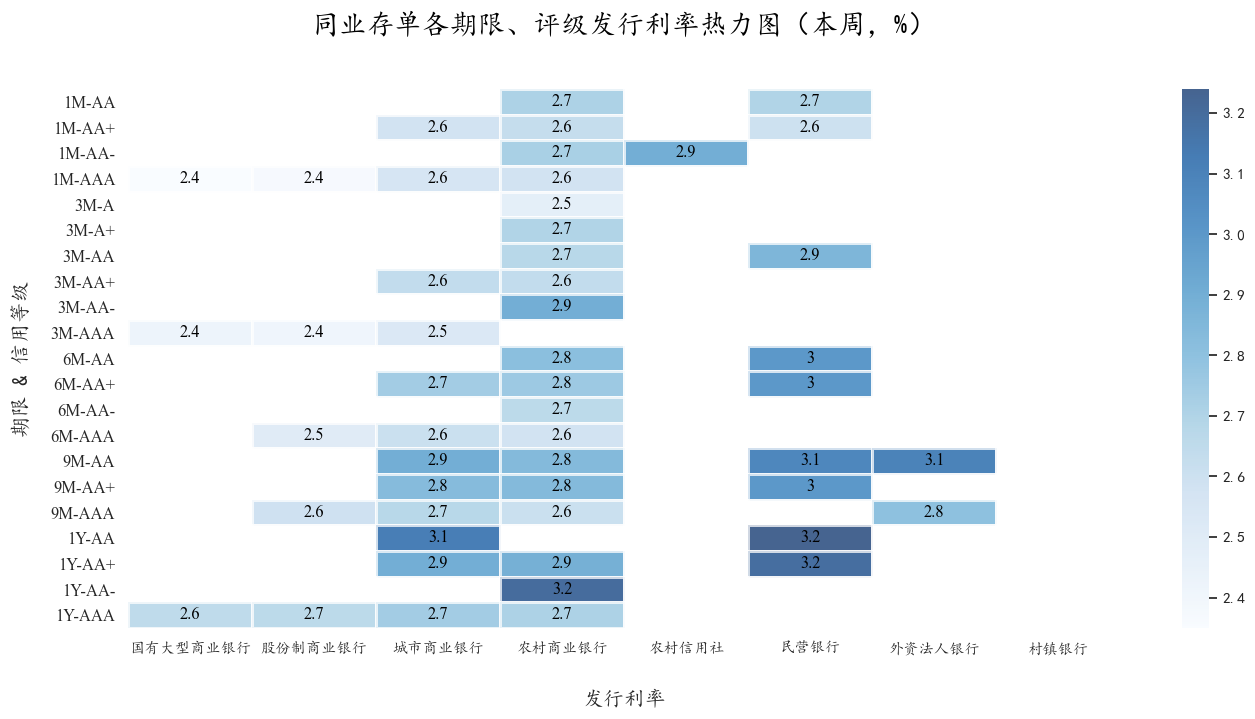

In [13]:
sns.set(font='KaiTi',style='white') #此行为正常显示中文：这里选择为楷体

plt.figure(figsize=(16,7))
# sns.set_context({"figure.figsize":(16,7)})
# sns.set_style('white') #有darkgrid（灰色背景+白网格）、whitegrid（白色背景+黑网格）、dark（仅灰色背景）、white（仅白色背景）
#                       #、ticks（坐标轴带刻度）5种预设的主题

sns.heatmap(CD_IR, annot=True, annot_kws={"family":"Times New Roman","size": 12,'color':'black'},cmap="Blues",cbar=True,
            cbar_kws={'orientation': 'vertical'},mask=False,linewidth=.8,linecolor='white',alpha=0.75,square=False)
# 【好看的cmp】：后面加"_r"即代表色带相反——Greens Oranges OrRd summer summer_r vlag Wistia Blues RdBu_r Reds

# annot: 默认为False，为True的话，会在格子上显示数字
# annot_kws={"family":"Times New Roman","size": 12,'color':'black'} 修改方格内字体大小、颜色等
# mask可以设置条件判断，如：mask=(CD_IR<=0)
# square : 为‘True’时，整个网格为一个正方形
# cbar=True——显示右方颜色条

plt.title('同业存单各期限、评级发行利率热力图（本周，%）', fontsize = 20,color='black',fontweight='bold',
          bbox=dict(ec='w',fc ='white'), #facecolor(简写fc)背景颜色, edgecolor(简写ec)边框线条颜色                                                   
          fontstyle='normal',family='KaiTi',pad =40  # pad为调整标题与图片的距离
         )
plt.xlabel('发行利率',family='KaiTi', fontsize = 15, fontweight='bold', labelpad=25) 
plt.ylabel('期限 & 信用等级',family='KaiTi',fontweight='bold',fontsize = 15, labelpad=15)

# #调整y轴【刻度】统一靠左对齐——但是会把图片遮住，暂时不知道怎么处理
plt.yticks(fontsize=10,fontproperties = 'Times New Roman',verticalalignment='center_baseline')

#horizontalalignment='left',multialignment='left',
# horizontalalignment，控制文本的 x 位置参数，对齐左侧、中心或右侧:'center', 'right', 'left'
# verticalalignment 控制文本的 y 位置参数，对齐底部、中心或顶部:'top', 'bottom', 'center', 'baseline', 'center_baseline'
# multialignment，仅用于换行符分隔的字符串，控制不同的行是左对齐、居中还是右对齐。


#~~~~以下方法为尝试解决问题的思路：由于更改了y轴刻度为靠左对齐，导致和图片有重叠（不好看）——但都不成功
# plt.gca().yaxis.tick_right()
# plt.yticks(fontsize=10, fontproperties = 'Times New Roman', horizontalalignment='right')
# plt.subplots_adjust(left=0.1, bottom=0.1, right=1, top=0.9)
# plt.gca().yaxis.tick_right()
# plt.gca().yaxis.set_label_position("right")
# plt.subplots_adjust(left=0.03)

plt.show()

In [14]:
# 数据透视——发行利率【中位数】

CD_data.pivot_table(index=['term','Mainrating'],columns='issuer_banktype',aggfunc='median',fill_value="-",values='issuerate')

issuer_banktype 农村信用社 农村商业银行 国有大型商业银行 城市商业银行 外资法人银行 民营银行 股份制商业银行
term Mainrating                                                                                           
1M   AA               -         2.65              -              -           -         2.7           -    
     AA+              -         2.65              -          2.555           -         2.6           -    
     AA-            2.9          2.8              -              -           -           -           -    
     AAA              -          2.6         2.3506           2.57           -           -        2.37    
3M   A                -         2.47              -              -           -           -           -    
     A+               -          2.7              -              -           -           -           -    
     AA               -         2.65              -              -           -         2.8           -    
     AA+              -        2.675              -           2.65           -           -           -    
     AA-              -          2.9              -              -           -           -           -    
     AAA              -            -           2.42           2.53           -           -         2.4    
6M   AA               -          2.8              -              -           -         3.0           -    
     AA+              -         2.75              -           2.72           -         3.0           -    
     AA-              -        2.665              -              -           -           -           -    
     AAA              -        2.575              -            2.6           -           -       2.475    
9M   AA               -         2.85              -          2.905         3.1       3.075           -    
     AA+              -         2.85              -           2.81           -         3.0           -    
     AAA              -         2.61              -          2.635         2.8           -       2.575    
1Y   AA               -            -              -            3.2           -       3.275           -    
     AA+              -          2.9              -           2.88           -        3.25           -    
     AA-              -          3.2              -              -           -           -           -    
     AAA              -        2.695           2.65           2.73           -           -        2.66